In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from mymodule.DatabaseConnection import CRUD
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import importlib
import mymodule.DatabaseConnection  # first import
importlib.reload(mymodule.DatabaseConnection) 

<module 'mymodule.DatabaseConnection' from 'c:\\Projects\\Market\\mymodule\\DatabaseConnection.py'>

In [5]:
lo_stockdailyupdate = CRUD('stockdailyupdate',schema=None)

In [6]:
df_stocks = lo_stockdailyupdate.Read()

In [7]:
df_stocks.shape

(11418032, 9)

In [8]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418032 entries, 0 to 11418031
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   StockExchange  object 
 1   Symbol         object 
 2   Date           object 
 3   open           float64
 4   high           float64
 5   low            float64
 6   close          float64
 7   volume         int64  
 8   delivery       int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 784.0+ MB


In [9]:
df_stocks.head(5)

,StockExchange,Symbol,Date,open,high,low,close,volume,delivery
0,BSE,500008,2007-09-19,41.1154,42.0574,40.0072,40.4782,543279,0
1,BSE,500008,2007-09-20,40.6306,41.1708,39.6470,39.9933,111498,0
2,BSE,500008,2007-09-21,40.3674,40.9353,39.6886,39.8271,139758,0
3,BSE,500008,2007-09-24,40.0349,40.4089,39.0929,39.3699,66939,0
4,BSE,500008,2007-09-25,39.2037,39.6470,38.5803,38.6080,84693,0


In [10]:
df_stocks.isnull().sum()

StockExchange    0
Symbol           0
Date             0
open             0
high             0
low              0
close            0
volume           0
delivery         0
dtype: int64

In [11]:
# Filter for one stock (or loop for multiple later)
df = df_stocks[df_stocks['Symbol'] == 'VEDL'].copy()

# Sort by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [12]:
df.shape

(6241, 9)

In [13]:
df["20DMA"] = df["close"].rolling(20).mean()
df["50DMA"] = df["close"].rolling(50).mean()
df["100DMA"] = df["close"].rolling(100).mean()
df["200DMA"] = df["close"].rolling(200).mean()

In [14]:
df.shape

(6241, 13)

In [15]:
df.columns

Index(['StockExchange', 'Symbol', 'Date', 'open', 'high', 'low', 'close',
       'volume', 'delivery', '20DMA', '50DMA', '100DMA', '200DMA'],
      dtype='object')

In [16]:
features = ['open', 'high', 'low', 'close', 'volume'] #, '20DMA', '50DMA', '100DMA', '200DMA'] #, 'RSI', ]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [17]:
scaled_df

,open,high,low,close,volume
11037269,0.000073,0.000072,0.000058,0.000071,0.000310
11037270,0.000071,0.000100,0.000058,0.000090,0.001152
11037271,0.000104,0.000133,0.000080,0.000082,0.000503
11037272,0.000054,0.000100,0.000054,0.000090,0.000625
11037273,0.000078,0.000105,0.000079,0.000107,0.000827
...,...,...,...,...,...
11043505,0.943439,0.940215,0.941979,0.934921,0.031113
11043506,0.938608,0.946474,0.945415,0.952867,0.022974
11043507,0.961914,0.965437,0.965455,0.974875,0.023332
11043508,0.982378,0.978048,0.986926,0.980164,0.017935


In [18]:
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_df)):
    X.append(scaled_df.iloc[i-lookback:i].values)
    y.append(scaled_df.iloc[i]['close'])

X, y = np.array(X), np.array(y)

print("X shape:", X.shape)  # (samples, timesteps=60, features)
print("y shape:", y.shape)  # (samples,)

X shape: (6181, 60, 5)
y shape: (6181,)


In [19]:
X[0][59]

array([0.0006341 , 0.00064489, 0.00060713, 0.00061344, 0.00535487])

In [20]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [21]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output (predicting next-day price)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\Projects\Market\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 5.0963e-04 - val_loss: 9.4221e-05
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.4607e-04 - val_loss: 1.0460e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.1767e-04 - val_loss: 6.2561e-05
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.1057e-04 - val_loss: 1.1151e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 8.9973e-05 - val_loss: 6.2211e-05
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 8.7728e-05 - val_loss: 8.4167e-05
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.5745e-05 - val_loss: 8.8746e-05
Epoch 8/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 8.2504e-05 - val_loss: 5.2508e-05
Epoch 9/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.4897e-05 - val_loss: 5.4643e-05
Epoch 10/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 6.9405e-05 - val_loss: 1.0567e-04
Epoch 11/100
140/140 ━━━━━━━━━━━━━━━━━━

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


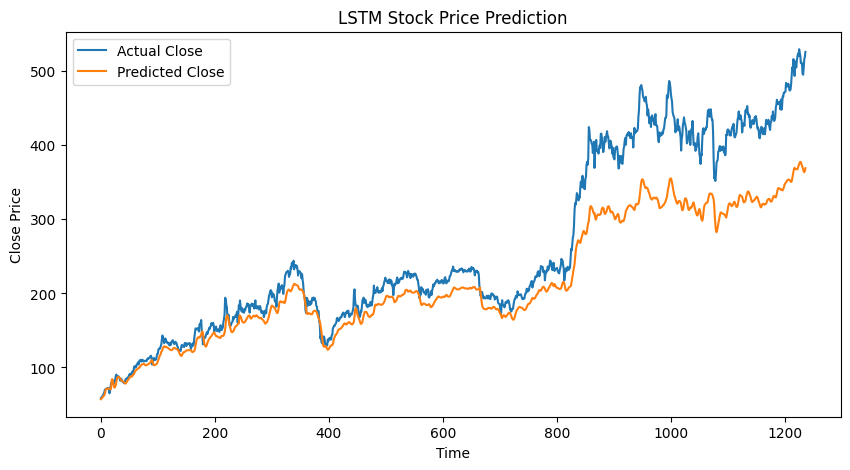

In [23]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)
#accuracy = accuracy_score(y_test, y_pred)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 3743.0803
RMSE: 61.1807
MAE : 44.1109
R²  : 0.7497


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


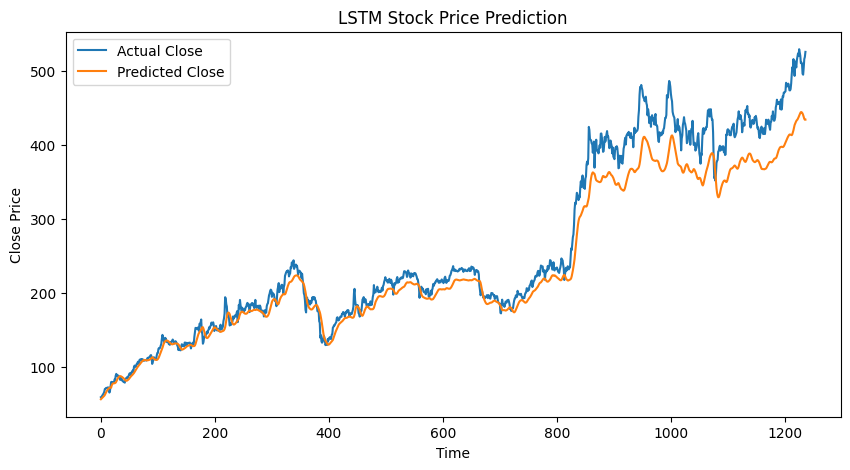

In [18]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

MSE : 1110.9992
RMSE: 33.3317
MAE : 24.1015
R²  : 0.9257


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


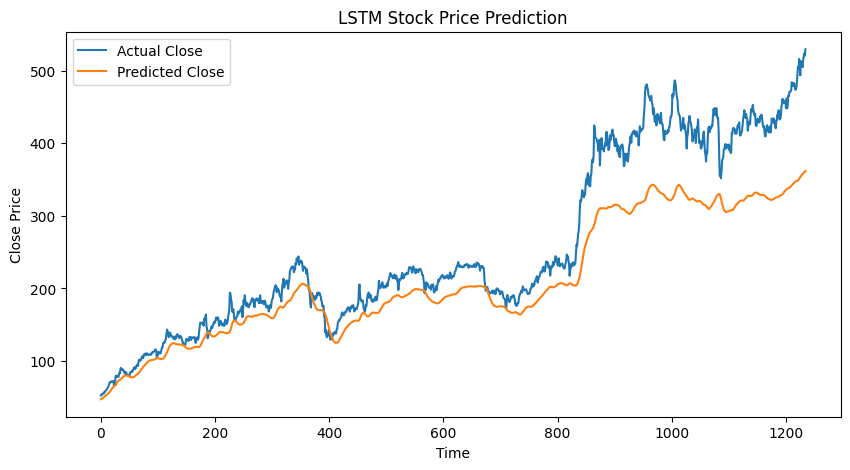

In [57]:
import matplotlib.pyplot as plt

# Predictions
y_pred = model.predict(X_test)

# Inverse scale for interpretability
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index('close')], scaler.scale_[features.index('close')]
y_test_inv = y_test / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_
y_pred_inv = y_pred / close_scaler.scale_ - close_scaler.min_ / close_scaler.scale_

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual Close')
plt.plot(y_pred_inv, label='Predicted Close')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()